# Лабораторная работа №1

**Цель работы:** изучить возможности библиотек Python для решения задач цифровой обработки сигналов.

**Задачи лабораторной работы:**

1. Освоить Jupyter Notebook.
2. Выполнить загрузку аудио сигнала и построить огибающую (график).
3. Фильтрация (выбрать один из 4 основных типов фильтров). Получить фильтрованный сигнал.
4. Детектор сигнал/шум. Получить сигнал после детектирования.
5. Эффект ”Эхо”. Получить сигнал после работы аудио-эффекта.
6. Бонусное задание: эффект ”Distortion”(классический вариант). Получить сигнал после работы аудио-эффекта.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from scipy.fftpack import fft
from scipy.io.wavfile import read, write
from scipy import signal

%matplotlib inline

In [2]:
def show_plt():
    plt.xlabel("Time [sec]")
    plt.ylabel("Amplitude")
    plt.title('03-01-05-01-01-02-02_A2.wav')
    plt.show()

**2. Постоение огибающей:**

Выполним загрузку аудио сигнала:

In [3]:
samplerate, data = read('03-01-05-01-01-02-02_A2.wav')
ipd.Audio('./03-01-05-01-01-02-02_A2.wav')

C:\Users\georg\AppData\Local\Temp/ipykernel_6032/550733832.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = read('03-01-05-01-01-02-02_A2.wav')


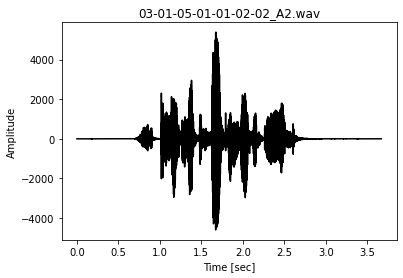

In [4]:
length = data.shape[0] / samplerate # data.shape := vector length
time = np.linspace(0., length, data.shape[0])

plt.plot(time, data, color="black")
show_plt()

Построим огибающую:

Имеется сигнал $ x(i) : i = 0,1,...,n - 1$.
Тогда огибающей будет такая последовательность $y(j) : j = 0,1,...,n - 1$, что
$$y(i) = 1/m * \sum \limits_{k=mj} ^{mj+m-1} |x(k)|$$
Пусть $m = [N/n]$ - число точек в интервале усреднения.

Т.е. огибающая последовательность это последовательность состоящий из смещающихся средних m значений
оригинальной последовательности.
Получается некое "сглаживание" оригинальной последовательности.

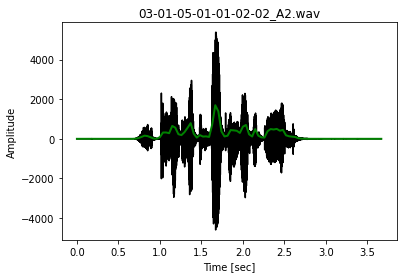

In [5]:
n = 100 # можно варьировать

m = int(data.shape[0] / n)
curve = np.linspace(0, length, n)
arr = []
# y(j) -- сохраним тоже как вектор значений
for j in range(n):
    sum = 0
    for k in range(m * j, m * j + m):
        sum += abs(data[k])
    arr.append(sum / m)

    
plt.plot(time,data, color="black")
plt.plot(curve, arr, linewidth=2, color="green")
show_plt()

**3. Фильтрация:**

Выбрать один из 4 основных типов фильтров (ФНЧ, ФВЧ, ПФ, РФ)

Был выбран тип фильтров ФВЧ (фильтр высоких частот)
Т.е. высокие частоты будут пропускаться, а ниже некого порога наоборот, подавляться.

Пусть $F_{d}$ - частота дискретизации, частота среза - $F_{s}$. Порядок фильтра - $m$. Тогда вычисляем
$$wn = 2*F_{s}/F_{d}$$

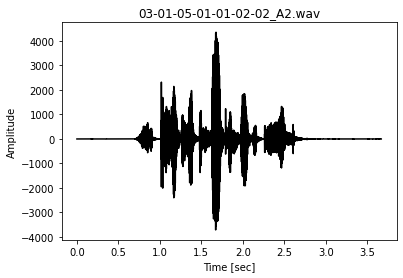

In [54]:
m = 1
F_s = 600 
wn = 2 * F_s / samplerate

_b,_a = signal.butter(m, wn, btype = 'highpass')
filtedData = signal.filtfilt(_b, _a, data)

plt.plot(time, filtedData, color="black")
show_plt()

In [56]:
filtedData = filtedData.astype(np.int16)
write("Highpass.wav", samplerate, filtedData)
ipd.Audio('./Highpass.wav')

**3. Амплитудный детектор сигнал/шум:**

Определяем среднее сигнала по амплитуде (без учета знака):
    $$mid = 1/N*\sum \limits_{k=0} ^{N-1}|x(k)|$$

Определяем порог детектора - $Th = \alpha * mid$, где $0 < \alpha < 1$ подбирается экспериментально.
Порог детектора -- это некоторая частота, рассчитаная на основе средней, отклонение от которой и будед регестрировать детектор.
Задаем чувствительность детектора - $k$, сколько требуется отсчетов, чтобы детектор заработал.
Обозначим $y(i)$ - сигнал после детектирования.

Если $x(i)$ в течении $k$ отсчетов превышает порог, $y(i) = x(i)$, порог преодолен.

Если $x(i)$ в течении $k$ отсчетов меньше порога, $y(i) = 0$, порог не достигнут.

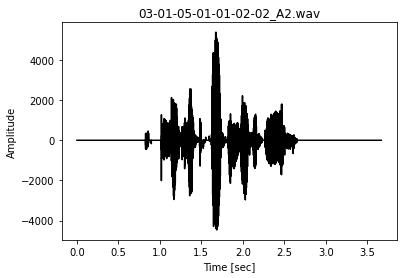

In [51]:
a = 0.3

sum = 0
for i in range(data.shape[0]):
    sum += abs(data[i])    
mid = sum / data.shape[0]

Th = a * mid

y = np.zeros(data.shape[0])

k = 20
surpassed = 0

for i in range(data.shape[0]):
    if abs(data[i]) >= Th:
        surpassed += 1
        if surpassed >= k:
            y[i] = data[i]
    else:
        surpassed = 0

plt.plot(time, y, color="black")
show_plt()

In [53]:
y = y.astype(np.int16)
write("detector.wav", samplerate, y)
ipd.Audio('./detector.wav')

**4. Эхо (простейший ревербератор)**

Ревербератор реализован, как набор линий задержки,
т.е. дубликатов с некоторыми модификациями, которые будут проигрываться чуть позже оригинала.
Число линий задержки $N_{L} >= 8$.
Каждая линия задержки имеет свой весовой коэффициент, сила каждого эхо в записи.
Чем раньше эхо, тем оно сильнее.

Перед добавлением к исходному сигналу, выход ревербератора фильтруется ФНЧ-фильтром первого порядка.
Желаемое соотношение между ”сухим” и обработанным сигналом задается коэффициентом применимости $\gamma$.
Ревербератор может работать в двух режимах: ручной и с использованием готовой конфигурации (preset). Для ручного режима регулируется пользователем задается максимальная задержка $D_1$, а величины остальных определяются автоматически через нее: 
$$D_i = D_12(1-i)/ N_L, i = 2, \dots,N_L.$$
Для готовой конфигурации пользователь вручную задает последовательность $$D_1> D_2 > \dots > D_{N_L}.$$

In [83]:
gamma = 0.9 # сила наложенного эхо
N_l = 10
D = [0 for i in range(N_l)]
a = [0 for i in range(N_l)]
D[0] = 20000
a[0] = 1

for i in range(1,N_l):
    D[i] = round(D[i - 1] / 2)
    a[i] = a[i - 1] / 2
    
fragments = []

for i in range(N_l):
    frag = [0 for i in range(D[i])]
    frag.extend(data)
    fragments.append([frag[j]*a[i] for j in range(len(frag))])

echo = fragments[0]
for i in range(1, N_l):
    for j in range(len(fragments[i])):
        echo[j] += fragments[i][j]
        
F_s = 300 
wn = 2 * F_s / samplerate

_b,_a = signal.butter(m, wn, btype = 'lowpass')
filted_echo = signal.filtfilt(_b,_a, echo)    

for i in range(len(filted_echo)):
    filted_echo[i] *= gamma
    
for i in range(len(data)):
    filted_echo[i] += data[i]

[20000, 10000, 5000, 2500, 1250, 625, 312, 156, 78, 39] [1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125]


In [86]:
filted_echo = np.array(filted_echo).astype(np.int16)
write("echo.wav",samplerate, filted_echo)
ipd.Audio('./echo.wav')

**5. Классический Distortion (опционально)**

Пользователь задает порог $Th$ и максимальное значение сигнала $Max > Th$. Тогда результат применения Distortion 
$$Y(i) = 
 \begin{cases} x(i), |x(i)| <= Th, \\ Max * sign(x(i)), |x(i)| > Th
 \end{cases}$$
 
 Т.е. если преодалевается порог, то сигнал "дотягивается" до максимального значения.
 В остальных случаях сигнал остается неизменным.

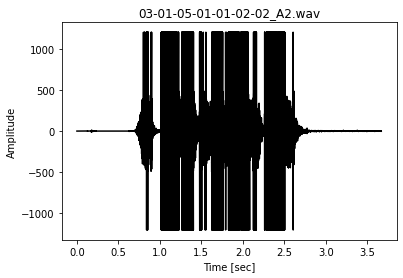

In [94]:
Th = 500
Max = 1200

arr = []
for i in range(len(data)):
    if abs(data[i]) <= Th:
        arr.append(data[i])
    else:
        arr.append(Max * np.sign(data[i]))

plt.plot(time, arr, color="black")
show_plt()  

In [95]:
dist_arr = np.array(arr).astype(np.int16)
write("distortion.wav",samplerate, dist_arr)
ipd.Audio('./distortion.wav')

**Вывод:**

В ходе выполнения лабораторной работы были применены на практике библиотеки языка Python: matplotlib, numpy, scipy, с помощью которых обрабатывались звуковые сигналы, был освоен Jupyter Notebook.

С помощью этих библиотек были созданы и опробованы на звуковом файле несколько типов фильтров.